In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import shutil
import os
import time


SOURCE_PATH = "/content/drive/MyDrive/images"
DESTINATION_PATH = "/content/local_dataset"

if os.path.exists(DESTINATION_PATH):
    print(f"Data already exists at {DESTINATION_PATH}. Skipping copy.")
else:
    print(f"Copying data from {SOURCE_PATH} to {DESTINATION_PATH}")
    shutil.copytree(SOURCE_PATH, DESTINATION_PATH)

Copying data from /content/drive/MyDrive/images to /content/local_dataset


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
LEARNING_RATE = 0.0001
EPOCHS = 60

In [4]:
from keras.utils import image_dataset_from_directory
train_path = "/content/local_dataset/train"
val_path   = "/content/local_dataset/val"
test_path  = "/content/local_dataset/test"

train_set = image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_set = image_dataset_from_directory(
    val_path,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_set = image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 3659 files belonging to 3 classes.
Found 783 files belonging to 3 classes.
Found 786 files belonging to 3 classes.


In [5]:
sets = ['train', 'val', 'test']
classes = ['COVID', 'PNEUMONIA', 'NORMAL']

print(f"{'Set':<10} {'Class':<15} {'Count':<10}")
print("-" * 35)

total_images = 0
path = "/content/local_dataset"
for set_name in sets:
    for class_name in classes:
        folder_path = os.path.join(path, set_name, class_name)

        try:
            files = [f for f in os.listdir(folder_path) if not f.startswith('.')]
            count = len(files)
            print(f"{set_name:<10} {class_name:<15} {count:<10}")
            total_images += count
        except FileNotFoundError:
            print(f"{set_name:<10} {class_name:<15} {'Not Found'}")

print("-" * 35)
print(f"Total Images Checked: {total_images}")

Set        Class           Count     
-----------------------------------
train      COVID           1138      
train      PNEUMONIA       1260      
train      NORMAL          1261      
val        COVID           243       
val        PNEUMONIA       270       
val        NORMAL          270       
test       COVID           245       
test       PNEUMONIA       270       
test       NORMAL          271       
-----------------------------------
Total Images Checked: 5228


In [6]:
from keras import mixed_precision
import tensorflow as tf
mixed_precision.set_global_policy('mixed_float16')
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
from keras.models import Sequential
from keras import layers
data_augmentation = Sequential([
    layers.RandomRotation(factor=0.03, fill_mode='constant', fill_value=0.0),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant', fill_value=0.0),
    layers.RandomContrast(factor=0.1)
])


In [8]:
from keras.applications import DenseNet121
from keras import regularizers, Model
from keras.optimizers import Adam
def build_model():

  inputs = layers.Input(shape=(224, 224, 3))

  x = data_augmentation(inputs)
  x = layers.Rescaling(scale=1./127.5, offset=-1)(x)

  base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  base_model.trainable = False
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4), use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Dropout(0.4)(x)
  outputs = layers.Dense(3, activation='softmax')(x)
  model = Model(inputs, outputs)
  return model


In [9]:
from keras.optimizers import Adam
model = build_model()
model.summary()
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,443 (27.85 MB)

 Trainable params: 263,427 (1.00 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

model_path = '/content/drive/MyDrive/densenet121_reducelr_model.keras'
history_path = '/content/drive/MyDrive/densenet121_reducelr_history.csv'

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

csv_logger = CSVLogger(history_path, append=True)
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stop, checkpoint, csv_logger, reduce_lr]
)

Epoch 1/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5928 - loss: 0.9420
Epoch 1: val_loss improved from inf to 0.61249, saving model to /content/drive/MyDrive/densenet121_reducelr_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.5939 - loss: 0.9398 - val_accuracy: 0.7305 - val_loss: 0.6125 - learning_rate: 1.0000e-04
Epoch 2/60
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8720 - loss: 0.3783
Epoch 2: val_loss improved from 0.61249 to 0.36315, saving model to /content/drive/MyDrive/densenet121_reducelr_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.8721 - loss: 0.3779 - val_accuracy: 0.8621 - val_loss: 0.3631 - learning_rate: 1.0000e-04
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9008 - loss: 0.3008
Epoch 3: val_loss improved from 0.36315 to 0.32318, saving model to /content/drive/MyDrive/densenet121_reducelr_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9008 - loss: 0

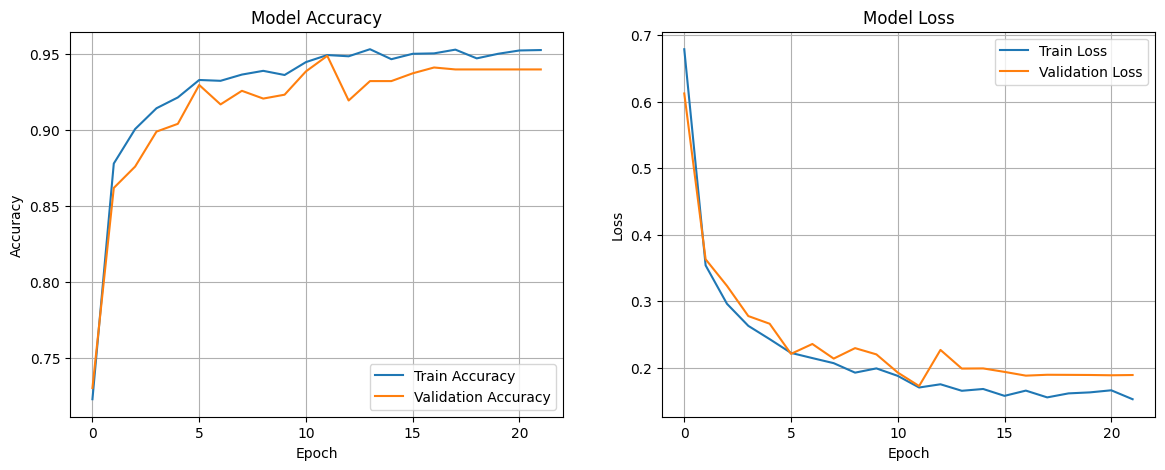

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

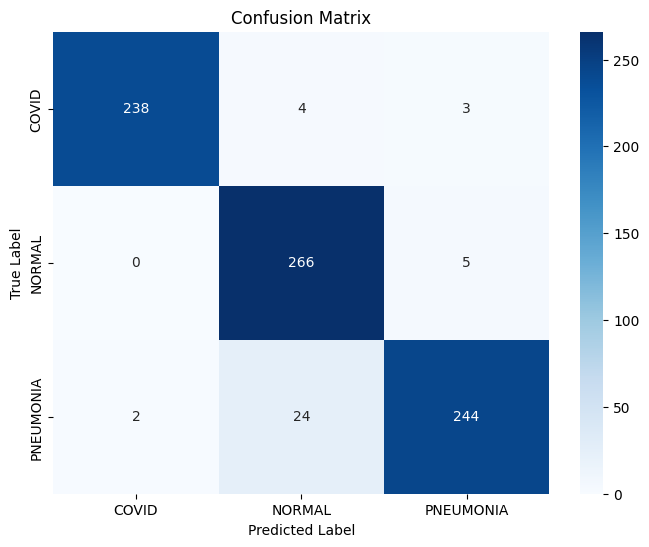

------------------------------
              precision    recall  f1-score   support

       COVID       0.99      0.97      0.98       245
      NORMAL       0.90      0.98      0.94       271
   PNEUMONIA       0.97      0.90      0.93       270

    accuracy                           0.95       786
   macro avg       0.95      0.95      0.95       786
weighted avg       0.95      0.95      0.95       786



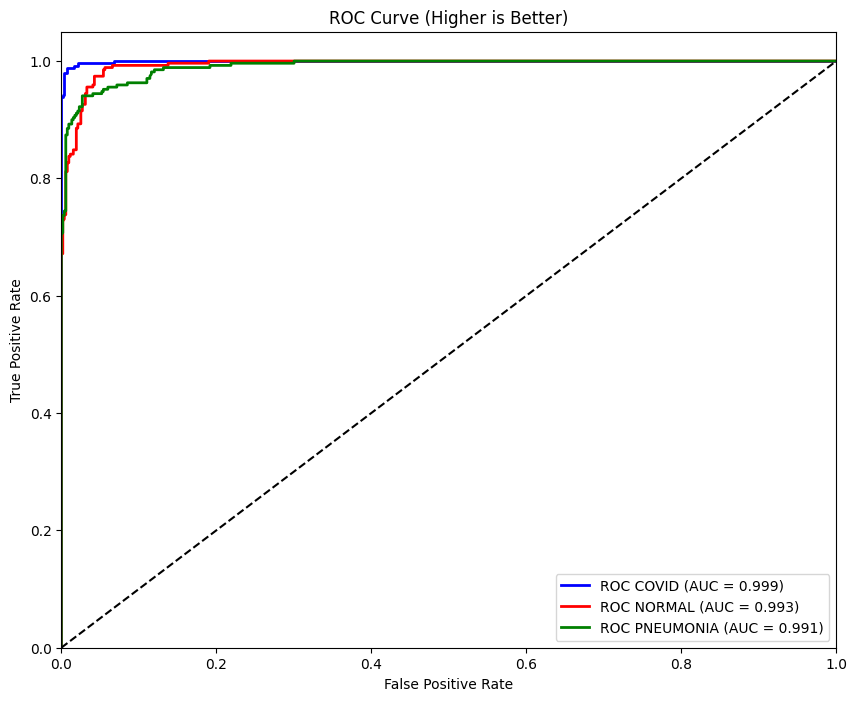

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf

model = tf.keras.models.load_model(model_path)
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']

y_true = []
y_pred_probs = []

for images, labels in test_set:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds)


y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print("-"*30)
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# ROC Curve
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
n_classes = len(class_names)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC {class_names[i]} (AUC = {roc_auc:0.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Higher is Better)')
plt.legend(loc="lower right")
plt.show()